# Tier 2. Module 2: Machine Learning. Fundamentals and Applications
## Topics 9-10 - Approaches to model quality improvement
## Homework

Construction of regression models to compare indicators of mutual information between features and the target variable with indicators of their importance for the predictive model (feature importance).

### 1. Loading the Autos dataset

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

with open('./datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

autos = datasets['autos']
print(autos.shape)
autos.head()

(193, 24)


,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


Feature engineering. Calculate and add the stroke ratio column to improve the quality of the model.

In [18]:
autos['stroke_ratio'] = autos['stroke'] / autos['bore']

autos[['stroke', 'bore', 'stroke_ratio']].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


### 2. Definition of the list of discrete features
Calculation of the index of mutual information requires the explicit definition of discrete features and the transformation of categorical features into discrete ones.

In [19]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               193 non-null    object 
 1   fuel_type          193 non-null    object 
 2   aspiration         193 non-null    object 
 3   num_of_doors       193 non-null    int64  
 4   body_style         193 non-null    object 
 5   drive_wheels       193 non-null    object 
 6   engine_location    193 non-null    object 
 7   wheel_base         193 non-null    float64
 8   length             193 non-null    float64
 9   width              193 non-null    float64
 10  height             193 non-null    float64
 11  curb_weight        193 non-null    int64  
 12  engine_type        193 non-null    object 
 13  num_of_cylinders   193 non-null    int64  
 14  engine_size        193 non-null    int64  
 15  fuel_system        193 non-null    object 
 16  bore               193 non

In [20]:
autos.describe()

,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,stroke_ratio
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,3.160622,98.923834,174.326425,65.893782,53.869948,2561.507772,4.419689,128.124352,3.330622,3.248860,9.860104,103.481865,5099.740933,25.326425,30.787565,13285.025907,0.982411
std,0.989583,6.152409,12.478593,2.137795,2.394770,526.700026,1.023182,41.590452,0.272385,0.315421,4.002098,37.960107,468.694369,6.387828,6.816910,8089.082886,0.125316
min,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,3.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000,0.632948
25%,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,98.000000,3.150000,3.110000,8.000000,70.000000,4800.000000,19.000000,25.000000,7738.000000,0.921965
50%,4.000000,97.000000,173.200000,65.400000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5100.000000,25.000000,30.000000,10245.000000,1.016760
75%,4.000000,102.400000,184.600000,66.900000,55.700000,2952.000000,4.000000,146.000000,3.590000,3.410000,9.000000,116.000000,5500.000000,30.000000,34.000000,16515.000000,1.069486
max,4.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000,1.294776


### 2.1. Definition of discrete features
From the analysis of the data set, we can conclude that the number of doors and cylinders are discrete features.

In [21]:
disc_features = ["num_of_doors", "num_of_cylinders"]

#### 2.2. Definition of categorical features

In [22]:
X = autos.copy()
y = X.pop('price')

cat_features = X.select_dtypes('object').columns

Transformation of categorical features into discrete.

In [23]:
for colname in cat_features:
    X[colname], _ = X[colname].factorize()

### 3. Calculation of the index of mutual information

In [24]:
mi_scores = mutual_info_regression(
    X, y,
    discrete_features=X.columns.isin(cat_features.to_list() + disc_features),
    random_state=42)

mi_scores = (pd.Series(mi_scores, name='MI Scores',
             index=X.columns).sort_values())

mi_scores.sample(5)

length               0.616900
height               0.360262
highway_mpg          0.870499
compression_ratio    0.090735
horsepower           0.894625
Name: MI Scores, dtype: float64

It is interesting to note that the addition of a new feature "Stroke ratio" did not improve this dataset, because the index of mutual information of the new feature turned out to be smaller than the index for "Bor" and on the same level as the "Stroke" included in it.

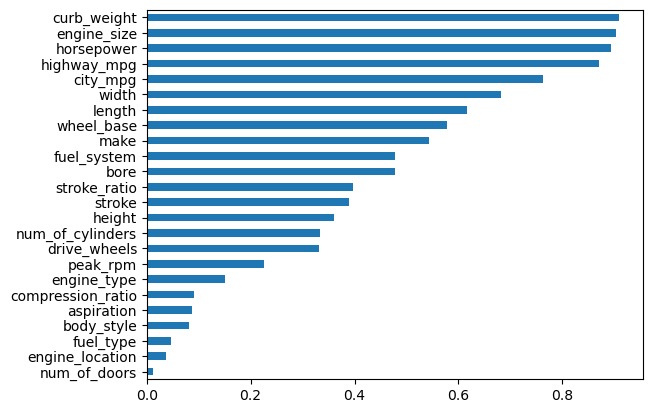

In [25]:
(pd.Series(
    data=mi_scores,
    index=X.columns)
    .sort_values(ascending=True)
    .plot
    .barh())

plt.show()

### 4. Construction of a regression model-ensemble
In this task, it is not required to evaluate the quality of the model, instead, it is necessary to evaluate the importance of each of the input features for a particular model. In addition, the number of samples is relatively small in this data set, and the rule of thumb of a 1:10 ratio between the number of features and the number of samples does not hold. Therefore, we decide not to divide the data into a training and validation sample and to inflate the model on the full data set.

#### 4.1. Features coding

In [26]:
X_train = autos.copy()
y_train = X_train.pop('price')

encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y)

scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)

#### 4.2. Random Forest Regressor

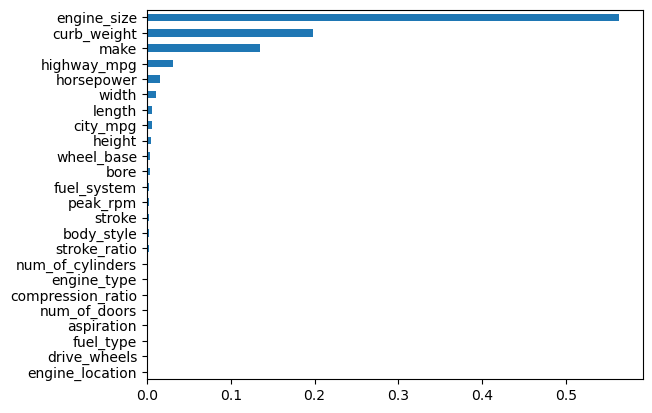

In [27]:
mod_rnd_frs = (RandomForestRegressor(random_state=42).fit(X_train, y_train))

(pd.Series(
    data=mod_rnd_frs.feature_importances_,
    index=X_train.columns)
    .sort_values(ascending=True)
    .plot
    .barh())

plt.show()

#### 4.3. Gradient Boosting Regressor

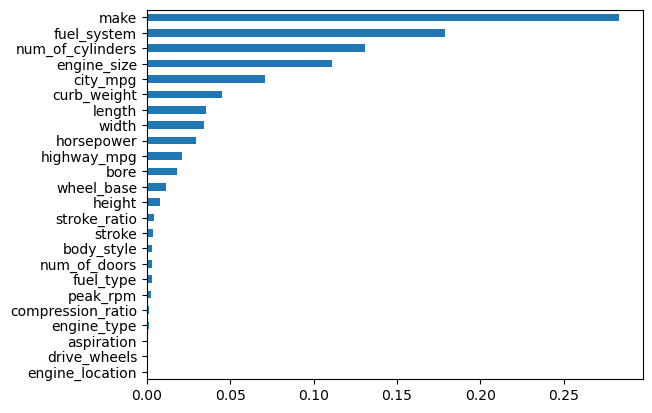

In [28]:
mod_grd_bst = (GradientBoostingRegressor(
    learning_rate=0.3,
    subsample=0.75,
    max_features='sqrt',
    random_state=42).fit(X_train, y_train))

(pd.Series(
    data=mod_grd_bst.feature_importances_,
    index=X_train.columns)
    .sort_values(ascending=True)
    .plot
    .barh())

plt.show()

### 5. Unification of the features importance with the index of mutual information

In [29]:
mod_rnd_frs_feats = pd.Series(
    mod_rnd_frs.feature_importances_, index=X.columns)
mod_rnd_frs_feats_ranked = mod_rnd_frs_feats.rank(pct=True)

mod_grd_bst_feats = pd.Series(
    mod_grd_bst.feature_importances_, index=X.columns)
mod_grd_bst_feats_ranked = mod_grd_bst_feats.rank(pct=True)

### 6. Visualization of feature importances with the index of mutual information

In [55]:
features_df = pd.DataFrame({
    'Features': mi_scores.index.sort_values(),
    'Mutual Information Index': mi_scores.sort_index().values,
    'Random Forest Regressor': mod_rnd_frs_feats_ranked.sort_index().values,
    'Gradient Boosting Regressor': mod_grd_bst_feats_ranked.sort_index().values,
})

features_df_sorted = features_df.sort_values("Mutual Information Index")
features_df_sorted

,Features,Mutual Information Index,Random Forest Regressor,Gradient Boosting Regressor
18,num_of_doors,0.011409,0.208333,0.333333
7,engine_location,0.036912,0.041667,0.041667
11,fuel_type,0.047298,0.125000,0.291667
1,body_style,0.080485,0.416667,0.375000
0,aspiration,0.087755,0.166667,0.125000
4,compression_ratio,0.090735,0.250000,0.208333
9,engine_type,0.150524,0.291667,0.166667
19,peak_rpm,0.224904,0.500000,0.250000
6,drive_wheels,0.332490,0.083333,0.083333
17,num_of_cylinders,0.332900,0.333333,0.916667


The DataFrame should be reshaped from wide format to long format for catplot

In [56]:
features_df_melted = features_df_sorted.melt(id_vars='Features', value_vars=['Mutual Information Index', 'Random Forest Regressor', 'Gradient Boosting Regressor'],
                                      var_name='Regressor', value_name='Feature importance')

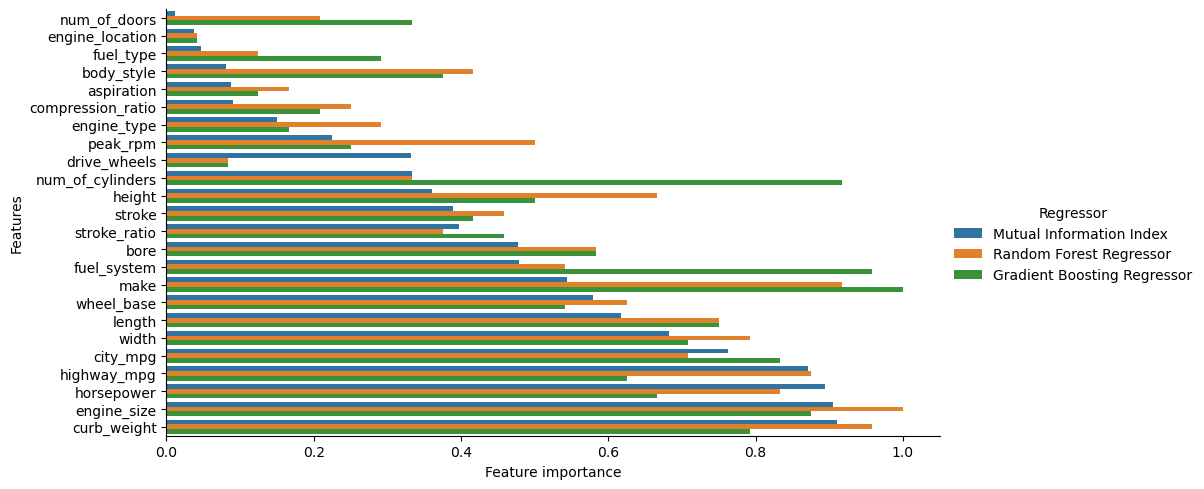

In [57]:
sns.catplot(
    data=features_df_melted,
    kind='bar',
    x='Feature importance',
    y='Features',
    hue='Regressor',
    height=5,
    aspect=2
)

plt.show()

### 7. Conclusions

As can be seen from the joint plot, the feature importances obtained by different regressors generally coincide for the most of features. The mutual information index gives most importance to car weight, size, and horsepower, random forest favors the same features plus make and height and gradient boost favors make, fuel systen, and number of cylinders the most. Part of the reason for this significant discrepancy is that the data set was not cleaned of multicollinearity, and one regressor might pick up one feature and ignore another collinear feature, while another regressor might do the opposite. The only thing in which all regressors are unanimous is that the newly formed feature of the stroke ratio does not add much quality to the already existing features.